# FEMM Modeling via pyFEMM

## Setup

In [ ]:
# If not already installed, Install FEMM and then install pyfemm with the following:
!pip install pyfemm

In [4]:
# Github: Clone typFEMM repo
!pip install tpyfemm@git+https://github.com/12Tall/tpyFEMM

  Cloning https://github.com/12Tall/tpyFEMM to c:\users\will\appdata\local\temp\pip-install-cr4w5x8s\tpyfemm_f10f6f5d6fbe408d9100646297c164dd


  ERROR: Error [WinError 2] The system cannot find the file specified while executing command git version
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?


In [354]:
# Load Libraries
import time # , re

import numpy as np
from scipy.integrate import trapz

import keyboard
import win32gui #, win32con

import femm
import matplotlib.pyplot as plt
plt.style.use('ggplot'); # 'seaborn-white'
from PIL import Image

In [355]:
# The package must be initialized with the openfemm command.
femm.openfemm(); 

time.sleep(1)

# Move Window
femm_window = win32gui.GetForegroundWindow();
win32gui.MoveWindow(femm_window, 1000, 200, 800, 800, True)

# We need to create a new Magnetostatics document to work on.
femm.newdocument(0);

# Change active Window
time.sleep(0.1)
keyboard.press('alt+tab')
keyboard.release('tab')
time.sleep(0.1)
keyboard.release('alt')

## Magnetics Pre Processing - 'mi'

In [356]:
## Define the problem type.  Magnetostatic; Units of mm; 'planar' or Axisymmetric; 
# Precision of 10^(-8) for the linear solver; a placeholder of 0 for 
# the depth dimension, and an angle constraint of 15 degrees
femm.mi_probdef(0, 'millimeters', 'planar', 1.e-8, 0, 15);

In [357]:
## Use FEMM library Materials
femm.mi_getmaterial('Air')
# femm.mi_getmaterial('1006 Steel')
femm.mi_getmaterial('NdFeB 32 MGOe')
femm.mi_getmaterial('Mumetal')

## Add Custom Materials
# femm.mi_addmaterial('Air', 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0);
femm.mi_addmaterial('Coil', 1, 1, 0, 0, 58*0.65, 0, 0, 1, 0, 0, 0);
femm.mi_addmaterial('LinearIron', 2100, 2100, 0, 0, 0, 0, 0, 1, 0, 0, 0);

# A more interesting material to add is the iron with a nonlinear
# BH curve.  First, we create a material in the same way as if we 
# were creating a linear material, except the values used for 
# permeability are merely placeholders.
femm.mi_addmaterial('Iron', 2100, 2100, 0, 0, 0, 0, 0, 1, 0, 0, 0);
# A set of points defining the BH curve is then specified.
bdata = [ 0.,0.3,0.8,1.12,1.32,1.46,1.54,1.62,1.74,1.87,1.99,2.046,2.08]; 
hdata = [ 0, 40, 80, 160, 318, 796, 1590, 3380, 7960, 15900, 31800, 55100, 79600];
for n in range(0,len(bdata)):
	femm.mi_addbhpoint('Iron', bdata[n],hdata[n]);
    
## Add a "circuit property" so that we can calculate the properties of the
# coil as seen from the terminals.
femm.mi_addcircprop('icoil', 20, 1);

### System Geometry - Magnets, Iron, and Coils

In [358]:
def addRectGeo(xc, yc, x, y, material, angle=0, mag_angle=0, group=0):  
    # By default North is up, angle rotates counter-clockwise [degrees].  
    x1, y1, x2, y2 = xc-x/2, yc-y/2, xc+x/2, yc+y/2  

    if angle == 0:  
        # Draw
        femm.mi_drawrectangle(x1, y1, x2, y2)  # (x1, y1, y2, x2)  
        femm.mi_addblocklabel(xc, yc)
        femm.mi_selectlabel(xc, yc)
        femm.mi_setblockprop(material, 0, 1, '<None>', mag_angle, group, 0)
        # Create Group
        femm.mi_selectlabel(xc, yc)
        femm.mi_selectrectangle(x1, y1, x2, y2, 4)
        femm.mi_setgroup(group)  # Create Group
    else:
        # Draw
        femm.mi_drawrectangle(x1, y1-100, x2, y2-100) # draw in x,-y quadrant
        femm.mi_addblocklabel(xc, yc-100)
        femm.mi_selectlabel(xc, yc-100)
        femm.mi_setblockprop(material, 0, 1, '<None>', mag_angle, group, 0)
        # Create Group
        femm.mi_selectlabel(xc, yc-100)
        femm.mi_selectrectangle(x1, y1-100, x2, y2-100, 4)  
        femm.mi_setgroup(group)  # Create Group  
        # Move to Final Position
        femm.mi_selectgroup(group)  
        femm.mi_moverotate(xc, yc-100, angle)  
        femm.mi_selectgroup(group)  
        femm.mi_movetranslate(0, 100)  # Return to +x,+y quadrant  

    femm.mi_clearselected()

In [359]:
# Define Geometry
x_offset = 30
y_offset = 2

# Draw Rectangle Magnets
addRectGeo(25+x_offset, 20+y_offset, 5, 20,
           'NdFeB 32 MGOe', mag_angle=180, group=2)
addRectGeo(33+x_offset, 18+y_offset, 10, 5,
           'NdFeB 32 MGOe', mag_angle=-90, group=3)  # Added 5 offset for howard Johnson Gate

addRectGeo(0, 7, 40, 2,
           'Mumetal', mag_angle=0, group=1)  # Sled Shielding
# Slanted Magnets
addRectGeo(43+x_offset, 20+y_offset, 5, 20, 'NdFeB 32 MGOe',
           -135, mag_angle=0, group=4)
addRectGeo(51+x_offset, 20+y_offset, 5, 20, 'NdFeB 32 MGOe',
           -135, mag_angle=0, group=5)
addRectGeo(59+x_offset, 20+y_offset, 5, 20, 'NdFeB 32 MGOe',
           -135, mag_angle=0, group=6)
addRectGeo(67+x_offset, 20+y_offset, 5, 20, 'NdFeB 32 MGOe',
           -135, mag_angle=0, group=7)
# addRectGeo(75+x_offset, 20+y_offset, 5, 20, 'NdFeB 32 MGOe',
#              -135, mag_angle=0, group=8)

# Mirror Geometry
for i in [1, 2, 3, 4, 5, 6, 7, 8]:  # range(2,3+1)
    femm.mi_selectgroup(i)
    # femm.mi_selectrectangle(-100, -100, 160, 100, 4) # x1,y1,x2,y2,editmode
    femm.mi_mirror(-60, 0, 160, 0)  # x1,y1,x2,y2

# addRectGeo(-22, 0, 2, 16,
#             'Mumetal', mag_angle=0, group=1) # Sled Shielding End Cap
# Sled / Rotor Magnet
addBarMagnet(0, 0, 40, 10, 'NdFeB 32 MGOe',
             mag_angle=180, group=1)  # (x, y, w, h) : 2,10,20,10 works

In [360]:
## View
femm.mi_zoomnatural()  
femm.mi_zoomout() 
# femm.mi_refreshview()

### Labels

In [361]:
# Label the boundary material  
femm.mi_addblocklabel(10, 30); # Air
femm.mi_selectlabel(10, 30);
femm.mi_setblockprop('Air', 0, 1, '<None>', 0, 0, 4);
femm.mi_clearselected()

In [362]:
# Define an "open" boundary condition using the built-in function:  
# femm.mi_makeABC()
femm.mi_makeABC(6, 120, 80, 0, 0) # (n, R, x, y, bc), originally '()'

# Set the boundary conditions
femm.mi_addboundprop('outside', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
# femm.mi_addboundprop('outside',0,0,0,0,0,0) # originally '('outside',0,0,0,0,0,0,0,0,0,0,0)'

In [363]:
## View
femm.mi_zoomnatural()  
# femm.mi_refreshview()

In [364]:
# We have to give the geometry a name before we can analyze it.
femm.mi_saveas('coil.fem');

# Now,analyze the problem and load the solution when the analysis is finished
femm.mi_analyze()
femm.mi_loadsolution()

time.sleep(1)

In [365]:
# Now, the finished input geometry can be displayed.
femm.mi_zoomnatural()  
# femm.mi_zoom(0, 0, 80, 60)  # x1, y1, x2, y2

In [366]:
# Save Analysis
femm.mi_savebitmap('Accelerator_Pre_Processing.bmp') # ("filename")  
# femm.mi_savemetafile('Output_Meta')  

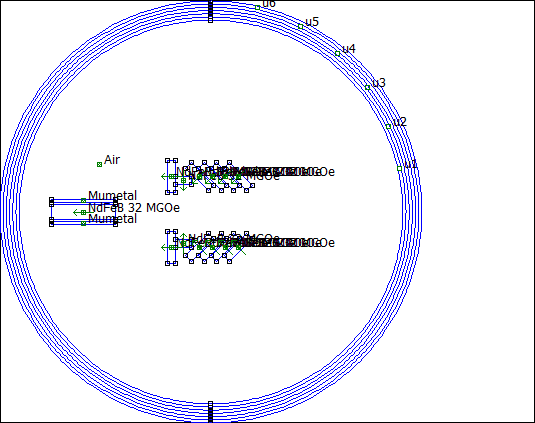

In [367]:
# Display Image
Image.open('Accelerator_Pre_Processing.bmp')

## Magnetics Post Processing - 'mo'

In [368]:
# Post-Process(legend, gscale, upper_B, lower_B, type); pyFEMM Manual pg.21
femm.mo_showdensityplot(1, 0, 0.000197118052262532, 0.516967928277248, 'bmag')

# Zoom Post Processing
# femm.mo_zoomnatural()
# femm.mo_zoom(0, 0, 80, 60)  # x1, y1, x2, y2

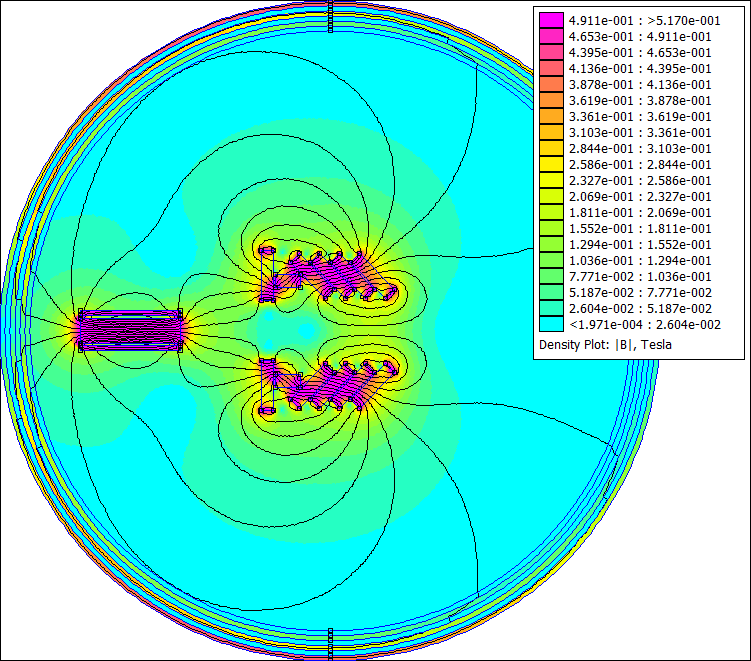

In [369]:
# Save Image of Port Processing
femm.mo_savebitmap('Accelerator_Post_Processing.bmp')

Image.open('Accelerator_Post_Processing.bmp')

## Analysis

### Basic Queries

In [209]:
# If we were interested in the flux density at specific positions,
# we could inquire at specific points directly:
b0 = femm.mo_getb(0, 0)
print('Flux density at the center of the bar is %g T' % b0[1])
b1 = femm.mo_getb(0, 50)
print('Flux density at r=0,z=50 is %g T' % b1[1])

# The program will report the terminal properties of the circuit:
# current, voltage, and flux linkage
vals = femm.mo_getcircuitproperties('icoil')

# [i, v, \[Phi]] = MOGetCircuitProperties["icoil"]

# If we were interested in inductance, it could be obtained by
# dividing flux linkage by current
L = 1000*vals[2]/vals[0]
print('The self-inductance of the coil is %g mH' % L)

Flux density at the center of the bar is -0.00920413 T
Flux density at r=0,z=50 is 0.0210426 T
The self-inductance of the coil is 0 mH


### Stress Tensor, Force, in X on Slide / Rotor

Iterations 18: 0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..

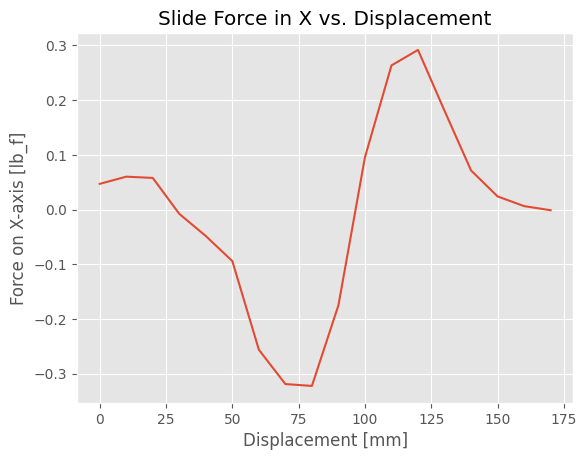

In [370]:
# Plot the force along a line, See appendix for Roters plunger example):
stroke = 170 # 120  # mm
step = 10  # Must be a factor of stroke
n = int(stroke/step) + 1  # number of steps: [0:n]

x = []  # Displacement
f = []  # Force on the slide / rotor magnet

print('Iterations %i: ' % (n), end='')

for k in range(0, n):
    print('%i..' % k, end='')
    # .fem window
    femm.mi_analyze()
    femm.mi_loadsolution()
    # .ans window - save result
    femm.mo_groupselectblock(1)
    x.append(stroke*k/(n-1))  
    f.append(femm.mo_blockintegral(18)/4.4481) # X-component of stress tensor [lb_f]
    # .fem window - Translate
    femm.mi_selectgroup(1)
    femm.mi_movetranslate(step, 0)
    # femm.mi_clearselected()

# Plot
plt.plot(x, f)
plt.ylabel('Force on X-axis [lb_f]')
plt.xlabel('Displacement [mm]')
plt.title('Slide Force in X vs. Displacement')
plt.show()

In [371]:
# Min/Max Force
print('Force_max =','{:.2f}'.format(max(f)), 'lb_f')
print('Force_min =','{:.2f}'.format(min(f)), 'lb_f')

Force_max = 0.29 lb_f
Force_min = -0.32 lb_f


Integral of force over distance is energy of system.    
Positive work done on slide, the slide accelerates in +X.  
Negative work done on slide, the slide decelerates in +x or requires a push.  

In [372]:
f_N = [i / 4.4482 for i in f] # Convert Force from lb_f to N  
x_m = [j / 0.001  for j in x] # Convert Distance in mm to m  

F_trap = trapz(f_N, x_m); # integral of force over distance  
print('Work of system is', '{:.1f}'.format(F_trap), '[W] on x-axis')  

Work of system is -337.7 [W] on x-axis


### Magnetic Flux density along a path

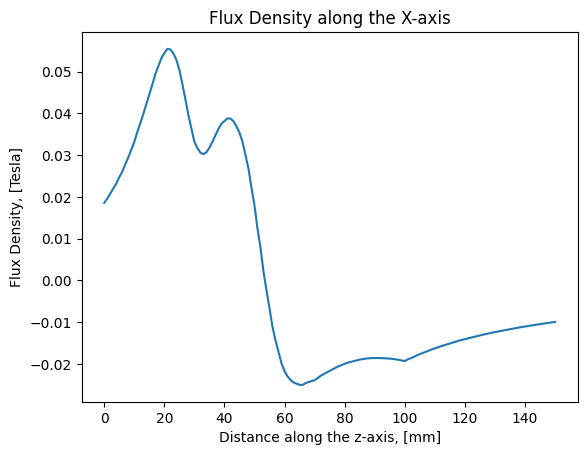

In [23]:
# Or we could, for example, plot the results along a line using
zee = []
bee = []
for n in range(0, 151):
    b = femm.mo_getb(n, 50) # n is hieght along 
    zee.append(n)
    bee.append(-b[1])

plt.plot(zee, bee)
plt.ylabel('Flux Density, [Tesla]')
plt.xlabel('Distance along the z-axis, [mm]')
plt.title('Flux Density along the X-axis')
plt.show()

In [173]:
# Return slide to original position
femm.mi_selectrectangle(-20, 0, 200, 18, 4)  # (x1, y1, x2, y2, editmode)
femm.mi_movetranslate(-stroke, 0)  # Return to +x,+y quadrant 

## ShutDown 

In [ ]:
# When the analysis is completed, FEMM can be shut down.
femm.closefemm();

## Appendix

### Herbert Roter's Magnet Force on Plunger 

In [ ]:
# Roters1b: Simulation of a Tapered Plunger Linear Actuator
# David Meeker
# dmeeker@ieee.org
#
# This geometry comes from Chap. IX, Figure 7 of Herbert Roters
# classic book, Electromagnetic Devices.  The program moves
# the plunger of the magnet over a stroke of 1.5in at 1/10in increments
# solving for the field and evaluating the force on the plunger at
# each position.  When all positions have been evaluated, the program
# plots a curve of the finite element force predictions.

import femm
import matplotlib.pyplot as plt

femm.openfemm()
femm.opendocument('roters1b.fem');
femm.mi_saveas('temp.fem');

n=16;
stroke=1.5;
x=[]
f=[]

for k in range (0,n):
	print('iteration %i of %i' % (k , (n-1)))
	femm.mi_analyze()
	femm.mi_loadsolution()
	femm.mo_groupselectblock(1)
	x.append(stroke*k/(n-1))
	f.append(femm.mo_blockintegral(19)/4.4481)
	femm.mi_selectgroup(1)
	femm.mi_movetranslate(0,-stroke/(n-1));
	femm.mi_clearselected()
# femm.closefemm()

plt.plot(x,f)
plt.xlabel('Displacement, Inches');
plt.ylabel('Force, Lbf');
plt.title('Plunger Force vs. Displacement');
plt.show()

### Generate Corners of Rectangle at any angle

In [ ]:
def get_corners_of_rectangle(center: [float, float], angle: float, dimensions: [float, float]):
    # create the (normalized) perpendicular vectors
    v1 = np.array([np.cos(angle), np.sin(angle)])
    v2 = np.array([-v1[1], v1[0]])  # rotate by 90

    # scale them appropriately by the dimensions
    v1 = v1 * dimensions[0] / 2
    v2 = v2 * dimensions[1] / 2
    
    # return the corners by moving the center of the rectangle by the vectors
    return [
        # center + v1 + v2,
        center - v1 + v2,
        # center - v1 - v2,
        center + v1 - v2
    ]

corners = get_corners_of_rectangle([0,0], math.radians(90), [10,5])
x1, y1, x2, y2 = corners[0][0], corners[0][1], corners[1][0], corners[1][1]
print(x1, y1, x2, y2)